# Traffic Flow Modeling and Analysis in the Los Angeles Highway System

In [14]:
# Import needed packages 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import cvxpy as cp
import scipy.io
import scipy

[(1, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (3, 9), (4, 5), (4, 9), (5, 14), (6, 7), (6, 10), (7, 8), (7, 10), (8, 9), (8, 11), (9, 13), (9, 12), (13, 14), (13, 17), (14, 17), (10, 11), (10, 15), (11, 12), (11, 15), (15, 16), (12, 13), (16, 17)]


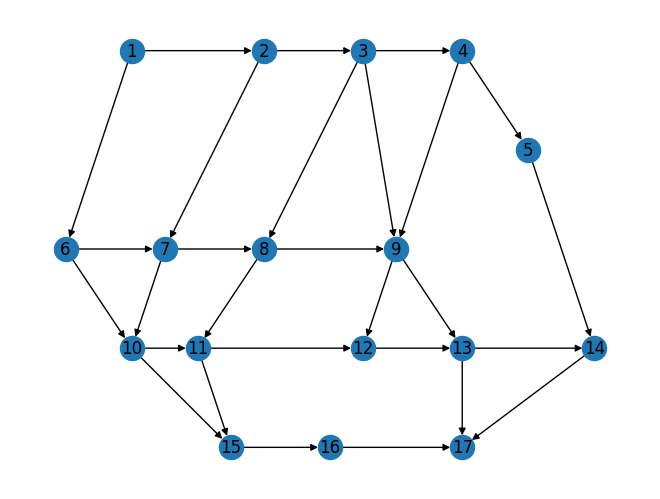

In [11]:
# Reading needed file from .mat files and creating capacities, traveltime, flow, and traffic
capacities = scipy.io.loadmat('capacities.mat').get('capacities').reshape(28, )
traveltime = scipy.io.loadmat('traveltime.mat').get('traveltime').reshape(28, )
flow = scipy.io.loadmat('flow.mat').get('flow').reshape(28, )
traffic = scipy.io.loadmat('traffic.mat').get('traffic')

# creating Graph
G = nx.DiGraph()

#creating node-edge incidence matrix
for edge in range(28):            #searching in edges
    capacity = capacities[edge]
    travtime = traveltime[edge]
    for r in range(17):        # check nodes the output edge of node i is the input node of j
        if traffic[r][edge] == 1:  
            i = r              #second node
        if traffic[r][edge] == -1:
            j = r              # first node
    G.add_edges_from([(i + 1, j + 1)], capacity=capacity, traveltime=travtime)

print(G.edges())

# Draw Graph
positions = {1: [0, 1], 2: [2, 1], 3: [3.5, 1], 4: [5, 1], 5: [6, 0],
             6: [-1, -1], 7: [0.5, -1], 8: [2, -1], 9: [4, -1],10: [0, -2],
             11: [1, -2], 12: [3.5, -2], 13: [5, -2], 14: [7, -2], 15: [1.5, -3],
             16: [3, -3], 17: [5, -3]}

nx.draw(G, positions, with_labels=True)

### a)

Here for finding the shortest path we could easily use shortest path using shortest_path() method. The key passed to this method is traveltime.

In [12]:
shortest_path = nx.shortest_path(G, 1, 17,'traveltime')
print('Shortest path from 1 to 17: ', shortest_path)

Shortest path from 1 to 17:  [1, 2, 3, 9, 13, 17]


### b)

We use max flow to find the maximum_flow of two nodes in a graph.

In [13]:
# Maximum Flow from 1 to 17:
max_flow_value, flows = nx.algorithms.flow.maximum_flow(G, 1, 17)
print('Maximum flow from node 1 to 17: ', max_flow_value)
print('Flow of the maximum from node 1 to 17: ', flows)


Maximum flow from node 1 to 17:  22448
Flow of the maximum from node 1 to 17:  {1: {2: 8741, 6: 13707}, 2: {3: 8741, 7: 0}, 3: {4: 0, 8: 0, 9: 8741}, 4: {5: 0, 9: 0}, 5: {14: 0}, 6: {7: 4624, 10: 9083}, 7: {8: 4624, 10: 0}, 8: {9: 4624, 11: 0}, 9: {13: 6297, 12: 7068}, 13: {14: 3835, 17: 10355}, 14: {17: 3835}, 10: {11: 825, 15: 8258}, 11: {12: 825, 15: 0}, 15: {16: 8258}, 12: {13: 7893}, 17: {}, 16: {17: 8258}}


### c)

Given the flow vector in flow.mat, compute the external inflow $\nu$ satisfying Bf = $\nu$. In the following, we assume that the exogenous inflow is zero in all the nodes except for node 1, for which $\nu_{1}$ has the same value computed in the point (c), and node 17, for which $\nu_{17}$ = -$\nu_{1}$

Regarding the inIncidence Matrix B that we created in the first section

In [14]:
np.set_printoptions(precision=2, suppress=True) #

# 'traffic' matrix -> the incidence matrix B of the graph
number_edges = traffic.shape[1] # number of edges

# Define exogenous flow vector:
# Set inflow at node 1 to 1 and outflow at node 17 to -1, with all other nodes having zero external flow
exogenous_flow = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]) 

l = np.array(traveltime) # link length vector
f = cp.Variable(number_edges) # flow vector

# l stores the coefficients of the linear terms of the objective function, in this case the length of the links.
# Add constraints
objective = cp.Minimize(l.T@f) # minimize Transpose l @ f
constraints = [exogenous_flow == traffic@f,f >= 0]      
problem = cp.Problem(objective, constraints)

# Output
# Set up and solve the optimization problem
optimal_cost = problem.solve()
print('Optimal f:', f.value) # The optimal value

external_inflow = traffic@flow
print('external inflow:', external_inflow)

Optimal f: [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]
external inflow: [ 16282   9094  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


/home/ali/Repos/University/NetworkDynamic/Homework1/.venv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


### d)

In [15]:
# Define exogenous inflow vector
exogenous_flow = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

f = cp.Variable(number_edges)

# defining cost function
function = cp.sum(cp.multiply(traveltime * capacities, cp.inv_pos(1 - cp.multiply(f, 1 / capacities))) - traveltime * capacities)

# Finding the Minimum cost function
# B_matrix is traffic
objective = cp.Minimize(function)
constraints = [traffic @ f == exogenous_flow, f >= 0, f <= capacities]  # 0 ≤ fe < ce.
problem = cp.Problem(objective, constraints)

optimal_cost = problem.solve()

optimal_flow = f.value

print(f'Social Optimal flow: {optimal_flow}') # Optimal value for
print(f'Optimal Cost: {optimal_cost}')

Social Optimal flow: [ 6642.2   6058.94  3132.33  3132.33 10163.8   4638.32  3006.34  2542.63
  3131.54   583.26     0.01  2926.6      0.    3132.33  5525.48  2854.27
  4886.45  2215.24   463.72  2337.69  3317.99  5655.68  2373.11     0.
  6414.12  5505.43  4886.45  4886.45]
Optimal Cost: 25943.62261121288


### e)

In [16]:
# Define f
f = cp.Variable(number_edges)

# Define cost function
func = cp.sum(- cp.multiply(traveltime * capacities, cp.log(1 - (cp.multiply(f, 1 / capacities)))))

objective = cp.Minimize(func) # minimize cost function

# Defining the constraints
constraints = [traffic @ f == exogenous_flow, f >= 0, f <= capacities]
problem = cp.Problem(objective, constraints) # Define the problem


wardrop_cost = problem.solve() # calculate wardrop cost

print('Wardrop equilibrium flow vector:', f.value)

Wardrop equilibrium flow vector: [ 6715.65  6715.65  2367.41  2367.41 10090.35  4645.39  2803.84  2283.56
  3418.48     0.     176.83  4171.41     0.    2367.41  5444.96  2353.17
  4933.34  1841.55   697.11  3036.49  3050.28  6086.77  2586.51     0.
  6918.74  4953.92  4933.34  4933.34]


### f)

Introduce tolls, such that the toll on link e is
$\omega_e$ = $f_e^\;* $ $\tau_e^\prime$ $(f_e^\;* $)
where $f_e^\;*$ is the flow at the system optimum. Now the delay on link e is given by
$\tau_e$($f_e$)+ $\omega_e$. 
compute the new Wardrop equilibrium $f^{(\omega)}$ . What do you observe?

In [17]:
wardrop_vector = f.value

print('Wardrop equilibrium without tolls:', wardrop_vector)

# cost, defined as \sum_e f_e d_e(f_e)
def cost(f):
    tot = []
    for i, value in enumerate(f):
        tot.append(((traveltime[i] * capacities[i]) / (1 - (value / capacities[i]))) - traveltime[i] * capacities[i])
    return sum(tot)

# Compute the cost of the Wardrop equilibrium
wardrop_cost = cost(wardrop_vector) # evaluate the social cost at the Wardrop equilibrium

print('Wardrop cost:', wardrop_cost)

# Compute the price of anarchy
PoA = wardrop_cost / optimal_cost

# Output
print('Cost without tolls:', wardrop_cost)
print('Optimal cost without tolls:', optimal_cost)
print('PoA:', PoA)

f = cp.Variable(number_edges) # flow vector


omega = [] # omega vector
for i, value in enumerate(optimal_flow):
    omega.append(value * ((capacities[i] * traveltime[i]) / ((capacities[i] - value) ** 2)))

# Define cost function
func = cp.sum(cp.multiply(omega, f) - cp.multiply(capacities * traveltime, cp.log(1 - (cp.multiply(f, 1 / capacities)))))

objective = cp.Minimize(func)
constraints = [traffic @ f == exogenous_flow, f >= 0, f <= capacities]
prob = cp.Problem(objective, constraints)

result = prob.solve()
print('Wardrop equilibrium with tolls:', f.value)

war_vect = f.value
# compute cost of wardrop equilibrium
wardrop_cost = cost(war_vect)

print('Wardrop cost w:', wardrop_cost)

PoA = wardrop_cost / optimal_cost
print('Cost with tolls:', wardrop_cost)
print('Optimal cost with tolls:', optimal_cost)

print('PoA:', PoA)

Wardrop equilibrium without tolls: [ 6715.65  6715.65  2367.41  2367.41 10090.35  4645.39  2803.84  2283.56
  3418.48     0.     176.83  4171.41     0.    2367.41  5444.96  2353.17
  4933.34  1841.55   697.11  3036.49  3050.28  6086.77  2586.51     0.
  6918.74  4953.92  4933.34  4933.34]
Wardrop cost: 26292.963874629393
Cost without tolls: 26292.963874629393
Optimal cost without tolls: 25943.62261121288
PoA: 1.013465400289377
Wardrop equilibrium with tolls: [ 6642.97  6059.08  3132.47  3132.47 10163.03  4638.26  3006.33  2542.34
  3131.49   583.9      0.    2926.6      0.    3132.47  5524.77  2854.23
  4886.37  2215.83   463.99  2337.45  3318.22  5655.67  2373.04     0.
  6414.12  5505.51  4886.37  4886.37]
Wardrop cost w: 25943.622615341876
Cost with tolls: 25943.622615341876
Optimal cost with tolls: 25943.62261121288
PoA: 1.0000000001591527


### g)

Instead of the total travel time, let the cost for the system be the total additional delay
compared to the total delay in free flow, given by $ψ_e(f_e) = f_e(τ_e(f_e) − l_e)$ 

subject to the flow constraints. Compute the system optimum $f^{\;*}$ for the costs above. Construct tolls ω∗such that the Wardrop equilibrium $f^{(\omega^\;*)}$ coincides with $f^{\;*}$. Compute the new Wardrop equilibrium with the constructed tolls $f^{(\omega^\;*)}$ to verify your result.

In [18]:
f = cp.Variable(number_edges)

# cost function free flow delay
func = cp.sum(cp.multiply(cp.multiply(traveltime, capacities), cp.inv_pos(1 - cp.multiply(f, 1 / capacities))) - cp.multiply(traveltime, capacities) - cp.multiply(traveltime, f))

objective = cp.Minimize(func)
constraints = [traffic @ f == exogenous_flow, f >= 0, f <= capacities]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
optimal_cost = prob.solve()

# The optimal value for f is stored in `f.value`.
optimal_flow = f.value
print('Social optimal flow:', optimal_flow)
print('Optimal cost:', optimal_cost)
w = cp.Variable(number_edges)

exogenous_flow = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

# cost function with optimal flow
integral = - cp.multiply(capacities * traveltime, cp.log(1 - (cp.multiply(optimal_flow, 1 / capacities)))) - cp.multiply( optimal_flow, traveltime) + cp.multiply(w, optimal_flow)
func = cp.sum(integral)

objective = cp.Minimize(func)
constraints = [traffic @ w == exogenous_flow, w >= 0]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print('Constructed tolls:', w.value)
constr_tolls = w.value

f_new = cp.Variable(number_edges)
exogenous_flow = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

func = - cp.multiply(capacities * traveltime, cp.log(1 - (cp.multiply(f_new, 1 / capacities)))) 
- cp.multiply(f_new,traveltime) + cp.multiply(constr_tolls, f_new)

objective = cp.Minimize(cp.sum(func))
constraints = [traffic @ f_new == exogenous_flow, f_new >= 0, f_new <= edge, f_new == optimal_flow]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print('Wardrop equilibrium:', f_new.value)


if f_new.value is not None:
    def cost2(f):
        tot = []
        for i, value in enumerate(f):
            tot.append(((l[i] * edge[i]) / (1 - (value / edge[i]))) - l[i] * edge[i] - l[i] * value)
        return sum(tot)
    

    war_vect = f_new.value
    wardrop_cost = cost2(war_vect)

    print('Wardrop cost:', wardrop_cost)
    PoA = wardrop_cost / optimal_cost
    print('PoA:', PoA)

Social optimal flow: [ 6653.3   5774.66  3419.72  3419.71 10152.7   4642.78  3105.84  2662.18
  3009.08   878.63     0.01  2354.94     0.01  3419.71  5509.92  3043.69
  4881.81  2415.57   443.66  2008.05  3487.35  5495.4   2203.78     0.
  6300.7   5623.49  4881.81  4881.81]
Optimal cost: 15095.51352460787
Constructed tolls: [16806.     0.     0.     0.     0.     0. 16806.     0.     0. 16806.
     0.     0.     0.     0.     0.     0.     0.     0. 16806.     0.
     0.     0.     0. 16806.     0.     0. 16806. 16806.]
Wardrop equilibrium: None
